# Notebook for Audio Classification Models
**Author : Ling Thang**
**Created on : 4/20/2025**

### Libraries

In [1]:
# general imports
import torch
import numpy as np
import os, random
import copy, math, time

# torch imports
import torch.nn as nn
import torch.nn.functional as F, torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader
import torch.optim as optim

# misc imports
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt


# Define the dataset

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, label_to_id, transform=None):
        self.paths, self.labels = [], []
        for cls_name, idx in label_to_id.items():
            cls_dir = os.path.join(root_dir, cls_name)
            for f in os.listdir(cls_dir):
                if f.endswith(".npy"):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        spec = np.load(self.paths[i])
        spec = torch.from_numpy(spec).float().unsqueeze(0)
        if self.transform: spec = self.transform(spec)
        return spec, self.labels[i]

class MinMaxNorm:
    def __call__(self, x):
        return (x - x.min()) / (x.max() - x.min() + 1e-6)

class SpecAugment:
    def __init__(self, time_mask=30, freq_mask=12):
        self.time_mask, self.freq_mask = time_mask, freq_mask
    def __call__(self, x):
        _, n_mels, T = x.shape
        t = random.randint(0, self.time_mask)
        t0 = random.randint(0, max(1, T - t))
        x[:, :, t0:t0+t] = 0
        f = random.randint(0, self.freq_mask)
        f0 = random.randint(0, max(1, n_mels - f))
        x[:, f0:f0+f, :] = 0
        return x

# Train / Validation Split + DataLoader

In [3]:
ROOT = 'audioset_mel_spectrograms_fast'       # <‑ adjust if you renamed the dir

# 1) get every sub‑directory name (ignore hidden files like .DS_Store)
class_names = sorted(
    d for d in os.listdir(ROOT)
    if os.path.isdir(os.path.join(ROOT, d))
)

# 2) assign consecutive integers
label_to_id = {cls: idx for idx, cls in enumerate(class_names)}
print(label_to_id)

# 3) (optional) save for reproducibility
os.makedirs('data', exist_ok=True)
np.save('data/label_to_id.npy', label_to_id, allow_pickle=True)

{'BellsHorns': 0, 'Keyboards': 1, 'Other': 2, 'Percussion': 3, 'Strings': 4, 'Wind': 5}


In [4]:
import os, numpy as np, torch
ROOT = 'audioset_mel_spectrograms_fast'
class_names = [d for d in os.listdir(ROOT) if os.path.isdir(os.path.join(ROOT,d))]
print("Classes:", class_names)

sample = os.path.join(ROOT, class_names[0], os.listdir(os.path.join(ROOT,class_names[0]))[0])
spec = np.load(sample)
print("Sample spec   :", sample)
print("Spec shape    :", spec.shape)    # expect (128, ~98)
print("Min/Max       :", spec.min(), spec.max())

Classes: ['Strings', 'BellsHorns', 'Other', 'Keyboards', 'Wind', 'Percussion']
Sample spec   : audioset_mel_spectrograms_fast/Strings/2XC0ckiiuq4_50_60_Banjo.npy
Spec shape    : (128, 801)
Min/Max       : -80.0 0.0


In [9]:
train_tf = T.Compose([MinMaxNorm(), SpecAugment()])
val_tf   = MinMaxNorm()
full_ds = SpectrogramDataset(ROOT, label_to_id)

label_to_id = np.load('data/label_to_id.npy', allow_pickle=True).item()

full_ds = SpectrogramDataset(ROOT, label_to_id)          # labels via ds.labels
labels  = full_ds.labels

sss = StratifiedShuffleSplit(test_size=0.15, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
train_ds.dataset.transform = train_tf   # plug transforms in
val_ds.dataset.transform   = val_tf

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# Model Definition

In [10]:
class LaraCNN(nn.Module):
    def __init__(self, num_classes=4):
        """
        Recreates the CNN architecture from Lara's paper for audio classification.

        Args:
            num_classes (int): The number of output classes. Lara used 4 (Piano, Drums, Flute, Other).
        """
        super(LaraCNN, self).__init__()
        # Input shape: (batch_size, 1, 128, 800) - (batch_size, channels, height, width)
        # This represents the mel-spectrogram, with 1 channel, 128 mel bins, and 800 time frames.

        # Block 1: Two Convolutional Layers -> BatchNorm -> ReLU -> MaxPool
        # As per the paper: kernel size 2, stride 1, padding 0 for Conv layers.
        # MaxPool kernel size 2.
        # Filter counts: 8, 8
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, stride=1, padding=0)
        self.conv1b = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=2, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Block 2: Two Convolutional Layers -> BatchNorm -> ReLU -> MaxPool
        # As per the paper: kernel size 2, stride 1, padding 0 for Conv layers.
        # MaxPool kernel size 2.
        # Filter counts: 16, 16
        self.conv2a = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=0)
        self.conv2b = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Block 3: Two Convolutional Layers -> BatchNorm -> ReLU -> MaxPool
        # As per the paper: kernel size 2, stride 1, padding 0 for Conv layers.
        # MaxPool kernel size 2.
        # Filter counts: 32, 32
        self.conv3a = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.conv3b = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully Connected Layer
        # We need to calculate the size of the flattened feature map after the last pooling layer.
        # Input shape: (batch_size, 1, 128, 800)
        # After conv1a (k2, s1, p0): 128-1 = 127, 800-1 = 799. Shape (batch_size, 8, 127, 799)
        # After conv1b (k2, s1, p0): 127-1 = 126, 799-1 = 798. Shape (batch_size, 8, 126, 798)
        # After pool1 (k2): 126/2 = 63, 798/2 = 399. Shape (batch_size, 8, 63, 399)
        # After conv2a (k2, s1, p0): 63-1 = 62, 399-1 = 398. Shape (batch_size, 16, 62, 398)
        # After conv2b (k2, s1, p0): 62-1 = 61, 398-1 = 397. Shape (batch_size, 16, 61, 397)
        # After pool2 (k2): floor(61/2) = 30, floor(397/2) = 198. Shape (batch_size, 16, 30, 198)
        # After conv3a (k2, s1, p0): 30-1 = 29, 198-1 = 197. Shape (batch_size, 32, 29, 197)
        # After conv3b (k2, s1, p0): 29-1 = 28, 197-1 = 196. Shape (batch_size, 32, 28, 196)
        # After pool3 (k2): 28/2 = 14, 196/2 = 98. Shape (batch_size, 32, 14, 98)
        self.flattened_size = 32 * 14 * 98

        # The text mentions filter counts up to 64, 64 which are not used in the Conv blocks as described.
        # Based on the diagram, there's a Flatten layer followed by a single FC layer.
        # The output of the final FC layer is 4 (for num_classes).
        self.fc1 = nn.Linear(self.flattened_size, num_classes)

        # Initialize weights using He initialization (Kaiming initialization in PyTorch)
        # which is suitable for ReLU activation functions.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        """
        Defines the forward pass of the CNN.

        Args:
            x (torch.Tensor): The input mel-spectrogram tensor
                              (batch_size, 1, 128, 800).

        Returns:
            torch.Tensor: The output logits for each class (batch_size, num_classes).
        """
        # Block 1
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2a(x)
        x = self.conv2b(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1) # Flatten starting from dimension 1 (channels)

        # Fully connected layer
        x = self.fc1(x)

        # Note: No Softmax here, as CrossEntropyLoss in PyTorch typically
        # expects raw scores (logits).

        return x

In [11]:
ds = SpectrogramDataset(ROOT, label_to_id, transform=MinMaxNorm())
X, y = ds[0]
print("Tensor shape :", X.shape)      # -> (1, 128, T)
model = LaraCNN(num_classes=len(label_to_id))
out = model(X.unsqueeze(0))           # add batch dim
print("Forward OK, logits shape:", out.shape)

Tensor shape : torch.Size([1, 128, 801])
Forward OK, logits shape: torch.Size([1, 6])


# Training and Evaluation

In [12]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model   = LaraCNN(num_classes=len(label_to_id)).to(device)
opt     = optim.Adam(model.parameters(), lr=1e-3)

BEST_ACC, PATIENCE, wait = 0, 3, 0
best_state = None

def run_epoch(model, loader, train=True):
    ep_loss, correct, total = 0., 0, 0
    model.train() if train else model.eval()
    loop = tqdm(loader, leave=False, desc='train' if train else 'val')
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            out   = model(X)
            loss  = F.cross_entropy(out, y)
            preds = out.argmax(1)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
        ep_loss += loss.item()*X.size(0)
        correct += (preds==y).sum().item()
        total   += y.size(0)
        loop.set_postfix(loss=loss.item())
    return ep_loss/total, correct/total

In [13]:
def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    total_loss = 0

    progress = tqdm(loader, desc=f"Epoch {epoch} [train]", leave=False)
    for X, y in progress:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss   = F.cross_entropy(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        # live update
        progress.set_postfix(loss=loss.item())

    return total_loss / len(loader.dataset)

def evaluate(model, loader, device, epoch):
    model.eval()
    correct = 0

    progress = tqdm(loader, desc=f"Epoch {epoch} [val]" , leave=False)
    with torch.no_grad():
        for X, y in progress:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()

    return correct / len(loader.dataset)

In [14]:
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(model, train_loader, True)
    val_loss, val_acc = run_epoch(model, val_loader, False)
    
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} || "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} | "
          f"time {time.time()-t0:.1f}s")

    # -- checkpoint & early‑stopping
    if val_acc > BEST_ACC + 1e-3:
        BEST_ACC, wait, best_state = val_acc, 0, copy.deepcopy(model.state_dict())
        torch.save(best_state, 'best_laracnn.pt')
        print("  📌 New best model saved.")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

# restore best weights
if best_state: model.load_state_dict(best_state)

train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 01 | train loss 68.7835 acc 0.241 || val loss 35.3647 acc 0.302 | time 42.8s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 02 | train loss 35.4459 acc 0.324 || val loss 33.1178 acc 0.310 | time 47.6s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 03 | train loss 26.2819 acc 0.364 || val loss 27.0738 acc 0.343 | time 44.9s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 04 | train loss 21.1106 acc 0.389 || val loss 22.5390 acc 0.343 | time 50.8s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 05 | train loss 17.5796 acc 0.428 || val loss 23.7141 acc 0.284 | time 47.2s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 06 | train loss 13.9697 acc 0.449 || val loss 20.7664 acc 0.422 | time 52.3s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 07 | train loss 12.2974 acc 0.493 || val loss 27.2764 acc 0.291 | time 52.9s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 08 | train loss 10.1826 acc 0.538 || val loss 19.3270 acc 0.347 | time 52.1s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 09 | train loss 9.1987 acc 0.541 || val loss 15.9919 acc 0.429 | time 52.2s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 | train loss 7.9562 acc 0.551 || val loss 17.1916 acc 0.418 | time 52.6s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 | train loss 7.2752 acc 0.551 || val loss 14.9427 acc 0.422 | time 52.6s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 | train loss 6.4725 acc 0.594 || val loss 17.1040 acc 0.466 | time 52.8s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 | train loss 6.8887 acc 0.571 || val loss 13.6567 acc 0.455 | time 53.0s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 | train loss 5.2864 acc 0.637 || val loss 14.5135 acc 0.410 | time 53.0s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 | train loss 4.6593 acc 0.670 || val loss 14.8148 acc 0.526 | time 53.4s
  📌 New best model saved.


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16 | train loss 4.8848 acc 0.648 || val loss 14.7726 acc 0.459 | time 55.0s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17 | train loss 3.8729 acc 0.672 || val loss 17.0667 acc 0.422 | time 62.2s


train:   0%|          | 0/48 [00:00<?, ?it/s]

val:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18 | train loss 3.8333 acc 0.686 || val loss 16.6735 acc 0.425 | time 73.7s
Early stopping triggered.


# Final Metrics and Confusion Matrix

              precision    recall  f1-score   support

  BellsHorns       0.54      0.50      0.52        26
   Keyboards       0.51      0.71      0.59        34
       Other       0.05      0.03      0.04        34
  Percussion       0.75      0.60      0.67        55
     Strings       0.49      0.64      0.55        77
        Wind       0.64      0.50      0.56        42

    accuracy                           0.53       268
   macro avg       0.50      0.50      0.49       268
weighted avg       0.52      0.53      0.51       268



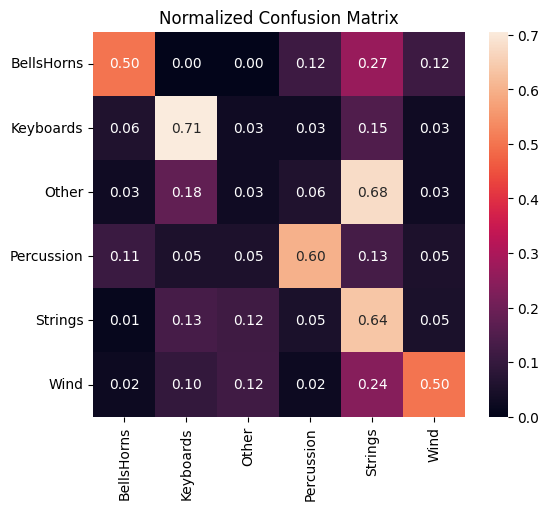

In [15]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        out = model(X.to(device))
        y_true.extend(y)
        y_pred.extend(out.argmax(1).cpu())

print(classification_report(y_true, y_pred,
                            target_names=list(label_to_id.keys())))

cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='rocket', xticklabels=label_to_id.keys(),
            yticklabels=label_to_id.keys(), fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()

# **Conclusion**

## Sample distribution of the dataset
| Class       | Count | Percent |
|-------------|-------|---------|
| Strings     | 512   | 25.2%   |
| Percussion  | 364   | 18.0%   |
| Wind        | 283   | 13.9%   |
| Keyboards   | 230   | 11.3%   |
| Other       | 226   | 11.1%   |
| BellsHorns  | 171   | 8.4%    |

String, Percussion, and Wind are the three most common classes

## Performance Overview

| Class       | Precision | Recall | F1   | Support (Val) | Notes                                                                 |
|-------------|-----------|--------|------|---------------|-----------------------------------------------------------------------|
| Percussion  | 0.75      | 0.60   | 0.67 | 55            | Excellent precision, decent recall. Model is confident and correct when it predicts this class. |
| Keyboards   | 0.51      | 0.71   | 0.59 | 34            | High recall, model tends to over-predict this class.                  |
| Strings     | 0.49      | 0.64   | 0.55 | 77            | Solid F1; consistent given it’s the largest class.                    |
| Wind        | 0.64      | 0.50   | 0.56 | 42            | Good precision, moderate recall.                                      |
| BellsHorns  | 0.54      | 0.50   | 0.52 | 26            | Decent balance given small sample size.                               |
| Other       | 0.05      | 0.03   | 0.04 | 34            | Poor performance. Mostly misclassified as Strings or Keyboards.     |


# Overall Performance

The model had a accuray score of 0.53, which is basically just as good as randomly guessing the classes. Of the classes the model is able to learn Percussion, Keyboards, and Strings the best (F1 scores ranked). Of the classes, Percussion was the most distinctive and the model was able to confidently predict it, which is shown in the high precision score. Worst of all the classes was Other, which has the worst F1 score of 0.04 which is so bad that it's honestly impressive. The near 0 score leads me to think that the data for other is just too broad or inconsistent to be able to learn any meaning up patterns. 

I wonder if binning all the musical labels into classes introduced too much noise into that dataset that made my models performance suffer. I would like to revisit my data preparation and see if I can find a better way to bin the classes. To push the performance even further, I would like to try using other models that lara mentioned in the paper. That was my original plan however I got caught up on the data preparation and was unable to get to it. Additionally, I really wanted to try using the attention mechanism from our in-class lectures to see if that would help the model learn the data better. I want to reproduce Lara's results and then try to improve upon them with different models and techniques, but I bit off more than I could chew. 

Future work would be to revisit my data preparation and retrieve more data from youtube. Additionally, processed the retrieved data even further to avoid the challenge of learning from an imbalanced dataset. Of course, I would also like to add a multi-layer attention mechanism to the model to see if that would help the model learn the data better. I expect that with these changes I will be able to reproduce lara's results and then improve upon them.